In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import os 

import tensorflow as tf
from keras.utils import load_img, img_to_array, to_categorical
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import Sequential

# import Dataset
trn = pd.read_csv('Train.csv')
tst = pd.read_csv('Test.csv')

# Checking the dataset

## correlation matrix

In [2]:
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [3]:
trn.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


C:\Users\hgvjh\AppData\Local\Temp\ipykernel_8240\2886335050.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


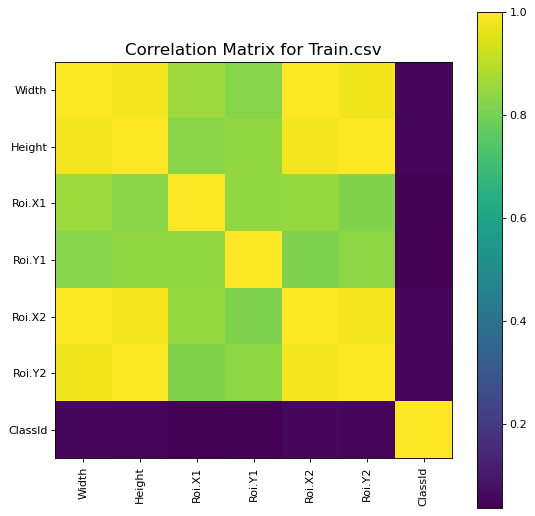

In [4]:
nRowsRead = 1000
trn.dataframeName = 'Train.csv'
nRow, nCol = trn.shape
plotCorrelationMatrix(trn, 8)

In [5]:
tst.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


C:\Users\hgvjh\AppData\Local\Temp\ipykernel_8240\2886335050.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


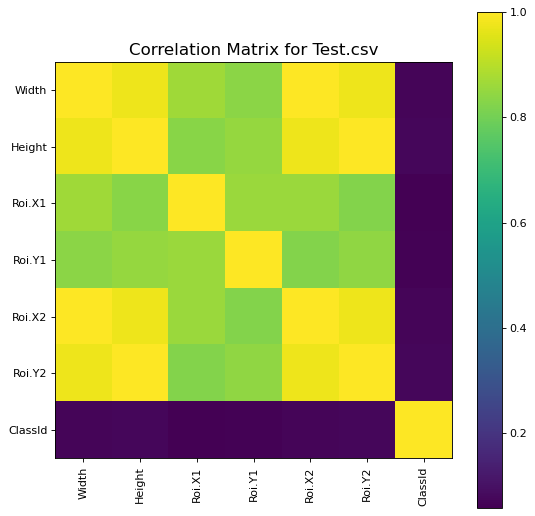

In [6]:
nRowsRead = 1000
tst.dataframeName = 'Test.csv'
nRow, nCol = tst.shape
plotCorrelationMatrix(tst, 8)

In [7]:
trn.info(), print('\n'), tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    12630 non-null  int64 
 1   Height   12630 non-null  int64 
 2   Roi.X1   12630 non-null  int64 
 3   Roi.Y1   12630 non-null  int64 
 4   Roi.X2   12630 non-null  int64 
 5   Roi.Y2   12630 non-null  int64 
 6   ClassId  12630 non-null  int64 
 7   Path     12630 non-null 

(None, None, None)

## Creating an array with the 43 labels

In [8]:
# Creating labels 
labels = {0:'Speed limit(20km/h)',
          1:'Speed limit(30km/h)',
          2:'Speed limit(50km/h)',
          3:'Speed limit(60km/h)',
          4:'Speed limit(70km/h)',
          5:'Speed limit(80km/h)',
          6:'End of speed limit(80km/h)',
          7:'Speed limit(100km/h)',
          8:'Speed limit(120km/h)',
          9:'No passing',
          10:'No passing for vehicles over 3.5 metric tons',
          11:'Right-of-way at the next intersection',
          12:'Priority road',
          13:'Yield',
          14:'Stop',
          15:'No vehicles',
          16:'Vehicles over 3.5 metric tons prohibted',
          17:'No entry',
          18:'General caution',
          19:'Dangerous curve to the left',
          20:'Dangerous curve to the right',
          21:'Double curve',
          22:'Bumpy road',
          23:'Slippery road',
          24:'Road narrows on the right',
          25:'Road work',
          26:'Traffic signals',
          27:'Pedestrians',
          28:'Children crossing',
          29:'Bicycles crossing',
          30:'Beware of ice/snow',
          31:'Wild animals crossing',
          32:'End of all speed and passing limits',
          33:'Turn right ahead',
          34:'Turn left ahead',
          35:'Ahead only',
          36:'Go straight or right',
          37:'Go straight or left',
          38:'Keep right',
          39:'Keep left',
          40:'Roundabout mandatory',
          41:'End of no passing',
          42:'End of no passing by vehicles over 3.5 metric tons'}

In [9]:
labels.values()

dict_values(['Speed limit(20km/h)', 'Speed limit(30km/h)', 'Speed limit(50km/h)', 'Speed limit(60km/h)', 'Speed limit(70km/h)', 'Speed limit(80km/h)', 'End of speed limit(80km/h)', 'Speed limit(100km/h)', 'Speed limit(120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibted', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons'])

## Modifying the train & test data

In [10]:
# getting only the Path and ClassId 
trn = trn[['ClassId', 'Path']]
tst = tst[['ClassId', 'Path']]

In [11]:
# add the complete path
trn['Path'] = trn['Path'].apply(lambda x:  x)
tst['Path'] = tst['Path'].apply(lambda x: x)

In [12]:
# Example of the new path in the data
print(f'The new path of the first image in "train_df" : {trn.Path[0]}')
print(f'The new path of the first image in "test_df" : {tst.Path[0]}')

The new path of the first image in "train_df" : Train/20/00020_00000_00000.png
The new path of the first image in "test_df" : Test/00000.png


## Plotting random images

image shape : (34, 34, 3)


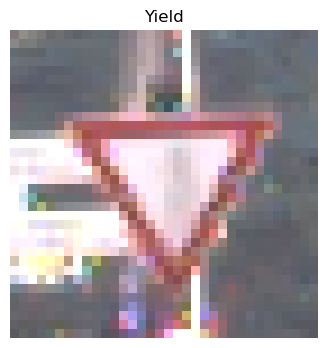

In [13]:
# create a random number
random_nbr = random.randint(1, len(trn)) # or randint(1, train_df.shape[0]))

# read a random image 
img = plt.imread(trn.Path[random_nbr]) 
print(f'image shape : {img.shape}')
fig, ax = plt.subplots(figsize=(8,4))

ax.imshow(img)
ax.set_title(labels[trn.ClassId[random_nbr]])
ax.axis('off')
plt.show()

## Preprocessing the images

In [14]:
# Split the data into training and validation sets
train_data = trn.sample(frac=0.8, random_state=0)
valid_data = trn.drop(trn.index)


# Preprocess the data
IMG_SIZE = 32
NUM_CLASSES = len(labels)

def preprocess_data(df):
    X = []
    y = []
    for index, row in df.iterrows():
        img = load_img(row.Path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = img_to_array(img) / 255.0
        X.append(img_array)
        y.append(to_categorical(row.ClassId, num_classes=NUM_CLASSES))
    return np.array(X), np.array(y)

X_train, y_train = preprocess_data(train_data)
X_valid, y_valid = preprocess_data(valid_data)
X_test, y_test = preprocess_data(tst)

In [15]:
print(f'The shape of X_train : {X_train.shape}')
print(f'The shape of X_test : {y_train.shape}')

The shape of X_train : (31367, 32, 32, 3)
The shape of X_test : (31367, 43)


# Building the model

## Model

In [16]:
# Definition of the model architecture (CNN)
model = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(2),
    Conv2D(128, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

### Visual representation of the CNN model

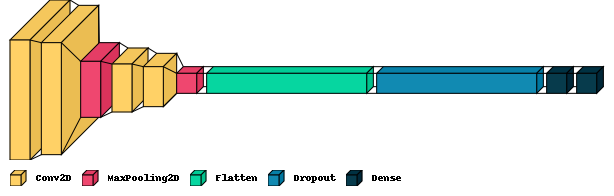

In [17]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                    

In [19]:
model.save('model.h5') #saving the model for furthur uses

### Fit the model

In [20]:
# fit the model
fitmodel = model.fit(X_train, 
                    y_train, 
                    epochs=5)

Epoch 1/5
981/981 [==============================] - 12s 7ms/step - loss: 1.0275 - accuracy: 0.7056
Epoch 2/5
981/981 [==============================] - 7s 7ms/step - loss: 0.1723 - accuracy: 0.9469
Epoch 3/5
981/981 [==============================] - 7s 7ms/step - loss: 0.1062 - accuracy: 0.9677
Epoch 4/5
981/981 [==============================] - 8s 8ms/step - loss: 0.0805 - accuracy: 0.9754
Epoch 5/5
981/981 [==============================] - 8s 8ms/step - loss: 0.0641 - accuracy: 0.9801


### Evaluating the model


In [21]:
loss, accuracy = model.evaluate(X_test, y_test)

395/395 [==============================] - 3s 5ms/step - loss: 0.1828 - accuracy: 0.9527


In [22]:
print("Testing Accuracy: {:.2f}%".format(accuracy * 100))


Testing Accuracy: 95.27%


### Predicting and plottting the results obtained from the model

395/395 [==============================] - 1s 3ms/step


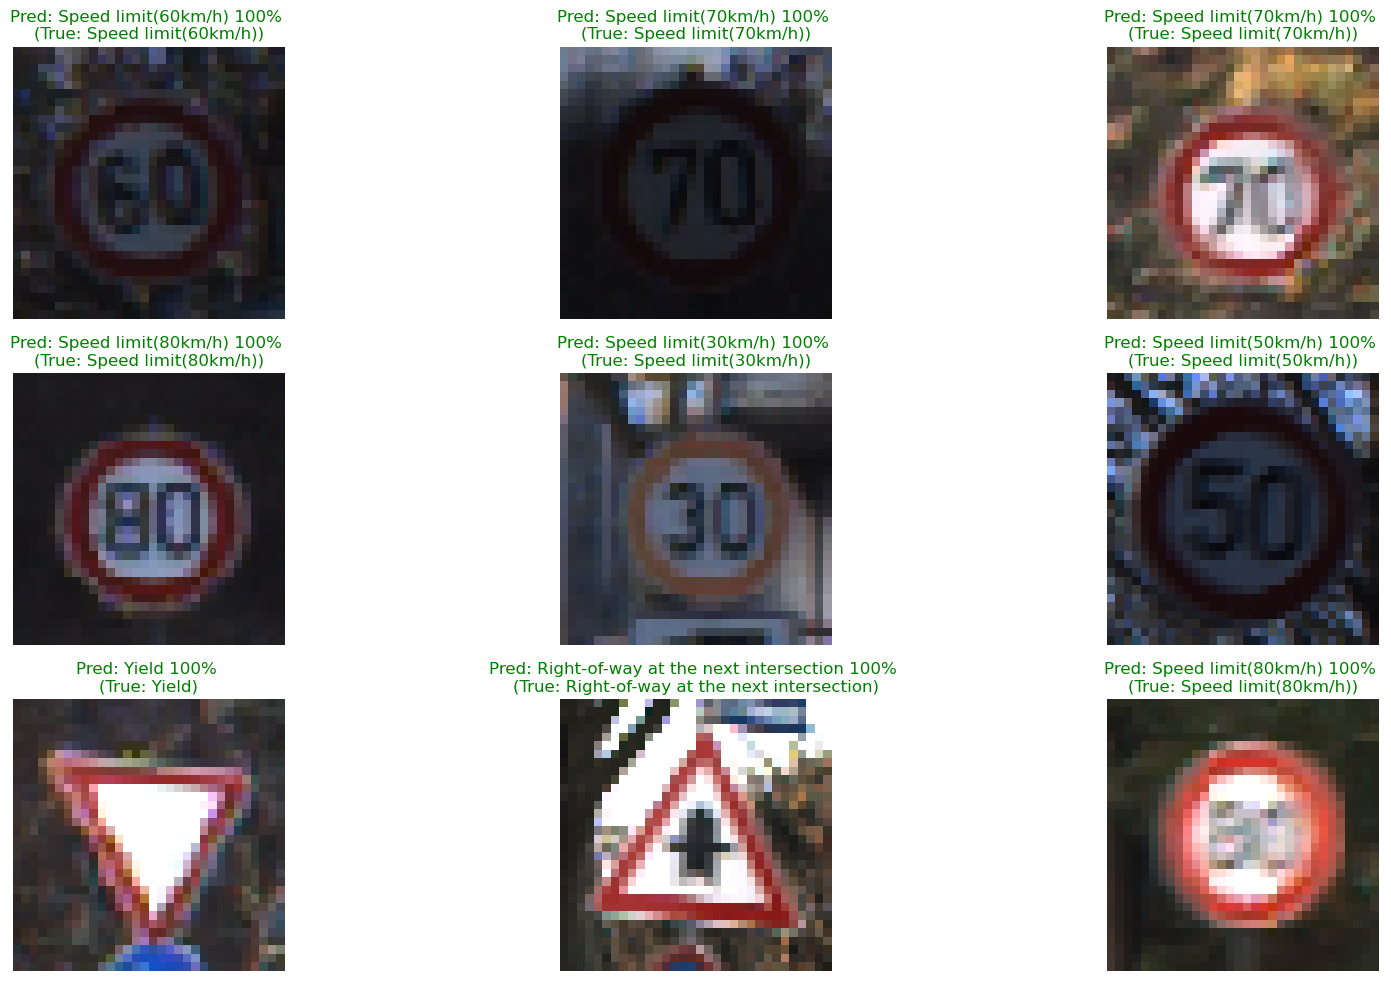

In [23]:
# generate 9 random numbers
rand_img = random.sample(range(len(X_test)), 9)

# Get the predicted labels for the test data
y_pred = model.predict(X_test)

# Plot the images and the predicted labels
fig, axs = plt.subplots(3, 3, figsize=(20, 12))
axs = axs.ravel()
for i in range(9):
  # Plot the image
  axs[i].imshow(X_test[rand_img[i]], cmap=plt.cm.binary)

  # Get the predicted and actual label indices
  pred_label = np.argmax(y_pred[rand_img[i]])
  true_label = np.argmax(y_test[rand_img[i]])

  if pred_label == true_label:
     color = "green"
  else:
     color = "red"

  # Set the label text
  axs[i].set_title("Pred: {} {:2.0f}% \n(True: {})".format(labels[pred_label],100*tf.reduce_max(y_pred),labels[true_label]),
             color=color)
  axs[i].axis('off')
plt.show()

In [24]:
img = plt.imread(trn.Path[random_nbr]) # read the image from the path
print(f'image shape : {img.shape}')

image shape : (34, 34, 3)
